In [77]:
import numpy as np
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

%matplotlib notebook

In [41]:
def file_len(path):
    with gzip.open(path, 'rb') as f:
        for i, _ in enumerate(f):
            pass
    return i + 1


class GenomeData:
    def __init__(self, name="chrom22", path="Data/22hap0.gz", verbose = True):
        self.name = name
        self.source_path = path
        self.verbose = verbose
        if self.verbose:
            print("Retrieving file length...")
        self.n_indiv = file_len(self.source_path)
        self.haploid0 = self.extract_data()
        self.haploid1, self.diploid = None, None

    def extract_data(self, path=None, verbose=None):
        if path is None:
            path=self.source_path
        if verbose is None:
            verbose=self.verbose
        if verbose:
            print("Extracting data from {}...".format(path))
        with gzip.open(path, 'rb') as f:
            for l in f:
                break
            s = l.decode('utf8')
            n = len(s.split())
            data = np.zeros((self.n_indiv,n), dtype=int)
            f.seek(0)
            for i,l in tqdm(enumerate(f), total=self.n_indiv):
                s = l.decode('utf8')
                data[i,] = np.array(list(map(float, s.split())))
        if verbose:
            print("\tdone.")
        return data
    
    def extract_labels(self, path="Data/ALL.chr22.integrated_phase1_v3.20101123.snps_indels_svs.genotypes.vcf.gz"):
        if self.verbose:
            print("Extracting patient IDs...")
        with gzip.open(path, 'rb') as f:
            for i,l in enumerate(f):
                if i == 29:
                    s = l.decode('utf-8')
                    idList = s.split()[9:]
                    break
        self.index_to_id = idList
        self.id_to_index = {idList[i]:i for i in range(len(idList))}
    
    def extract_haploid1(self):
        if self.verbose:
            print("Extracting second haploid data...")
        self.haploid1 = self.extract_data(self.source_path.replace('0', '1'))
        
    def build_diploid(self):
        if self.verbose:
            print("Building diploid data...")
        self.diploid = self.haploid0 + self.haploid1
    
    def extract_ethnicity(self, path='Data/integrated_call_samples.20101123.ALL.panel'):
        data = pd.DataFrame(columns=['patient', 'country', 'continent'])
        with open(path, 'r') as f:
            for i,l in enumerate(f):
                info = l.strip().split()
                data.loc[i] = info[:3]
        self.ethnicity = data
        
    def apply(self, method, i, j):
        pass
        
    def get_name(self):
        return self.name
        
    def get_haploid0(self):
        return self.haploid0
    
    def get_haploid1(self):
        if self.haploid1 is None:
            self.extract_haploid1()
        return self.haploid1
    
    def get_diploid(self):
        if self.diploid is None:
            self.build_diploid()
        return self.diploid
    
    def get_n_indiv(self):
        return self.n_indiv
    

In [1]:
pwd

'/home/vbillaut/Documents/Hash-based_patient_matching/Code'

In [42]:
test = GenomeData()

Retrieving file length...


  0%|          | 0/1092 [00:00<?, ?it/s]

Extracting data from Data/22hap0.gz...


100%|██████████| 1092/1092 [04:52<00:00,  3.73it/s]

	done.


In [33]:
def extractEthnicity(path='Data/integrated_call_samples.20101123.ALL.panel'):
    data = pd.DataFrame(columns=['patient', 'country', 'continent'])
    with open(path, 'r') as f:
        for i,l in enumerate(f):
            info = l.strip().split()
            data.loc[i] = info[:3]
    return data

In [34]:
ethnicity = extractEthnicity()

In [12]:
with gzip.open("Data/ALL.chr22.integrated_phase1_v3.20101123.snps_indels_svs.genotypes.vcf.gz", 'rb') as f:
    for i,l in enumerate(f):
        s = l.decode('utf-8')
        if i == 29:
            print(i, s.split()[9:])
            break

29 ['HG00096', 'HG00097', 'HG00099', 'HG00100', 'HG00101', 'HG00102', 'HG00103', 'HG00104', 'HG00106', 'HG00108', 'HG00109', 'HG00110', 'HG00111', 'HG00112', 'HG00113', 'HG00114', 'HG00116', 'HG00117', 'HG00118', 'HG00119', 'HG00120', 'HG00121', 'HG00122', 'HG00123', 'HG00124', 'HG00125', 'HG00126', 'HG00127', 'HG00128', 'HG00129', 'HG00130', 'HG00131', 'HG00133', 'HG00134', 'HG00135', 'HG00136', 'HG00137', 'HG00138', 'HG00139', 'HG00140', 'HG00141', 'HG00142', 'HG00143', 'HG00146', 'HG00148', 'HG00149', 'HG00150', 'HG00151', 'HG00152', 'HG00154', 'HG00155', 'HG00156', 'HG00158', 'HG00159', 'HG00160', 'HG00171', 'HG00173', 'HG00174', 'HG00176', 'HG00177', 'HG00178', 'HG00179', 'HG00180', 'HG00182', 'HG00183', 'HG00185', 'HG00186', 'HG00187', 'HG00188', 'HG00189', 'HG00190', 'HG00231', 'HG00232', 'HG00233', 'HG00234', 'HG00235', 'HG00236', 'HG00237', 'HG00238', 'HG00239', 'HG00240', 'HG00242', 'HG00243', 'HG00244', 'HG00245', 'HG00246', 'HG00247', 'HG00249', 'HG00250', 'HG00251', 'HG002

In [88]:
import pickle
import os
import distance
from multiprocessing import Pool


class ComparisonEngine:
    def __init__(self, data=None, channel = 'hap0', window_size = 1, metric='similarity', option = ''):
        self.genome_data = data
        self.channel = channel
        self.option = option
        self.metric_name = metric
        self.window_size = window_size
        if self.genome_data is not None:
            self.get_data()
        self.set_metric(self.metric_name)
        self.cache_filename = None
        
    def get_data(self):
        if self.channel == 'hap0':
            self.data = self.genome_data.get_haploid0()
        elif self.channel == 'hap1':
            self.data = self.genome_data.get_haploid1()
        elif self.channel == 'dip':
            self.data = self.genome_data.get_diploid()
        if self.option == 'test':
            self.data = self.data[:,:10000]
            
    def set_metric(self, metric):
        def hamming(x,y):
            return np.sum(np.abs(x-y))
        def similarity(x,y):
            d = hamming(x,y)
            return (len(x) + len(y) - d) * 1.0 / (len(x) + len(y) + d)
        if metric == 'hamming':
            self.metric = hamming
        if metric == 'similarity':
            self.metric = similarity
            
    def get_metric(self):
        return self.metric
            
    def init_filename(self):
        if not os.path.exists('Data/cache/'):
            os.mkdir('Data/cache/')
        self.cache_filename = 'Data/cache/{}_{}_{}_{}.pkl'.format(self.genome_data.get_name(),
#                                                                   self.genome_data.name,
                                                                  self.metric_name,
                                                                  self.window_size,
                                                                  self.option)
        
    def load_from_cache(self):
        if self.cache_filename is None:
            self.init_filename()
        result = pickle.load(open(self.cache_filename, 'rb'))
        return result
    
    def dump_to_cache(self, data):
        if self.cache_filename is None:
            self.init_filename()
        pickle.dump(data, open(self.cache_filename, 'wb'))
    
    def compute(self):
        n = self.genome_data.get_n_indiv()
#         n = self.genome_data.n_indiv
        matrix = np.zeros((n, n))
        test = np.array([0])
        for i in range(n):
            matrix[i,i] = self.metric(test, test)
        
        def compute_row(i):
            res = []
            for j in range(i+1,n):
                res.append(self.metric(self.data[i,], self.data[j,]))
            return res
        
#         pool = Pool(8)
#         results = pool.map(compute_row, list(range(n-1)))
#         pool.close()
#         pool.join()

        results = []
        for i in tqdm(range(n-1)):
            results.append(compute_row(i))
        
        for i in range(n-1):
            matrix[i+1:,i] = np.array(results[i])
            matrix[i,i+1:] = np.array(results[i])
            
        return matrix
    
    def compute_individual(self, i):
        pass
    
    def apply(self, force_recompute = False, force_dump = True):
        if not force_recompute:
            try:
                return self.load_from_cache()
            except:
                result = self.compute()
                if force_dump:
                    self.dump_to_cache(result)
                return result
        else:
            result = self.compute()
            if force_dump:
                self.dump_to_cache(result)
            return result
        
    def heatmap(self, **args):
        sns.heatmap(self.load_from_cache(), **args)
        plt.show()

In [89]:
CE = ComparisonEngine(test, option='test')

In [81]:
CE.data.shape

(1092, 10000)

In [83]:
CE.apply(force_recompute=True)

100%|██████████| 1091/1091 [00:42<00:00, 25.51it/s]


array([[ 1.        ,  0.90921674,  0.92252235, ...,  0.92613281,
         0.92113731,  0.91350938],
       [ 0.90921674,  1.        ,  0.9043085 , ...,  0.95198126,
         0.90403656,  0.92687509],
       [ 0.92252235,  0.9043085 ,  1.        , ...,  0.91451682,
         0.92169109,  0.89519568],
       ..., 
       [ 0.92613281,  0.95198126,  0.91451682, ...,  1.        ,
         0.91607588,  0.93208714],
       [ 0.92113731,  0.90403656,  0.92169109, ...,  0.91607588,
         1.        ,  0.900689  ],
       [ 0.91350938,  0.92687509,  0.89519568, ...,  0.93208714,
         0.900689  ,  1.        ]])

In [74]:
ls Data/cache/

chrom22_similarity_1_test.pkl


---
### benchmark distances

In [49]:
%time print([distance.hamming((np.random.random(200)>0.5), (np.random.random(200)>0.5)) for _ in range(10000)][:5])

[106, 96, 89, 99, 116]
CPU times: user 10.6 s, sys: 404 ms, total: 11 s
Wall time: 9.56 s


In [50]:
%time print([np.sum(np.abs((np.random.random(200)>0.5) != (np.random.random(200)>0.5))) for _ in range(10000)][:5])

[95, 108, 95, 103, 95]
CPU times: user 328 ms, sys: 40 ms, total: 368 ms
Wall time: 365 ms


`distance.hamming` is super slow, we need to use `numpy` instead.

---

### heatmap tests

In [84]:
matrix = CE.apply()

In [85]:
matrix.shape

(1092, 1092)

<IPython.core.display.Javascript object>


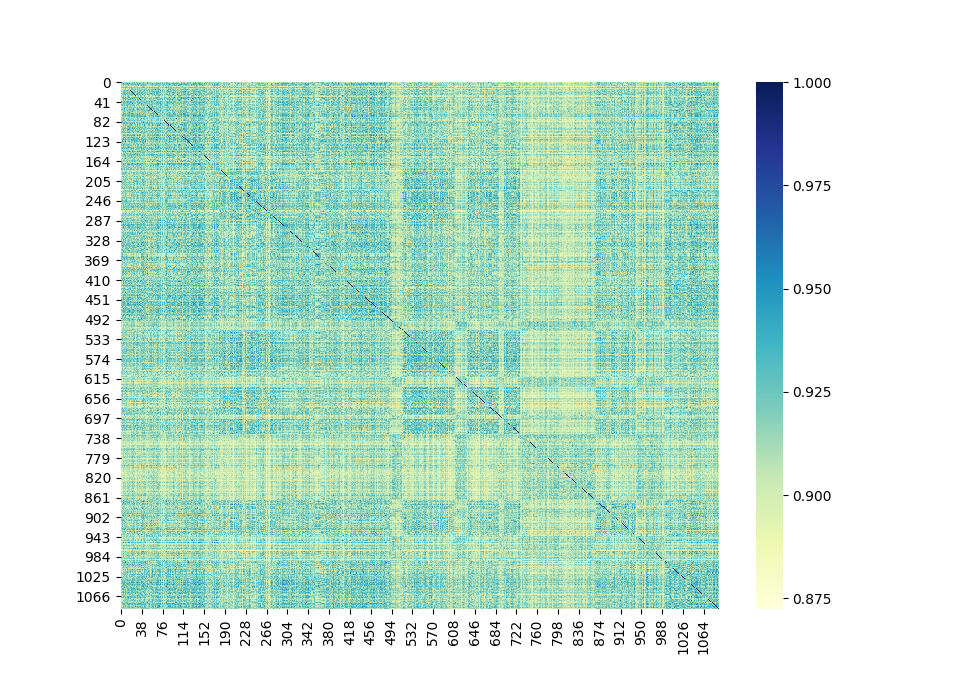

In [87]:
sns.heatmap(matrix, cmap="YlGnBu")

<IPython.core.display.Javascript object>


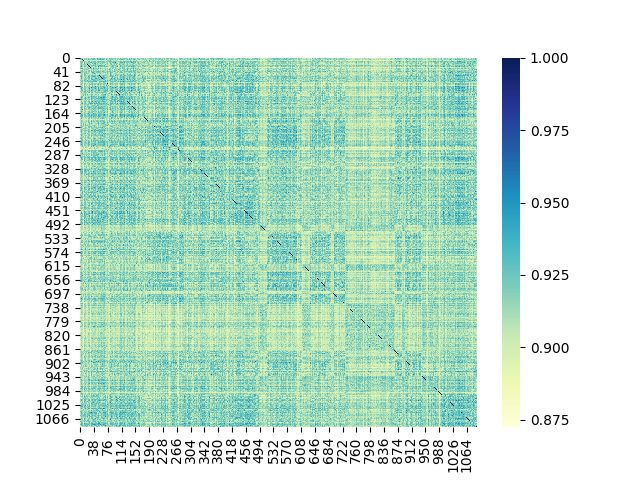

In [91]:
CE.heatmap(cmap="YlGnBu")

---

In [33]:
CE.get_metric()

<function __main__.ComparisonEngine.set_metric.<locals>.similarity>

In [34]:
CE.metric([0,0,0,1],[0,0,0,0])

0.7777777777777778

In [17]:
CE.get_metric('hamming')

In [18]:
CE.metric([0,0,0,1],[0,0,0,0])

0.25